# Causal Inference Modeling of COMPAS data

### Criterion for Bias
- 1) TP and TN Rate by Race
- 2) Intervention by Race
- 3) Counterfactual Fairness by Race
- 4) Natural Direct Effects Identification of Race to Recitivism
- 5) Natural Indirect Effects Identification of Race to Recitivism

### 3 SCMs of Race towards Recitivism Predictions
- 1) Indirect (Almost all expected, with some understandable results)
    - 1) TP and TN Rate by Race (Expected: 1 - 3% difference between race is understndable, but non zero value is expected)
    - 2) Intervention by Race (Expected: Small effect of around 5% is understandable, but not zero is expected)
    - 3) Counterfactual Fairness by Race (Expected: Large of 43%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: No effect detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: -24% of White -> Will not Recommit)
- 2) Direct (Expected)
    - 1) TP and TN Rate by Race (Expected: Large bias)
    - 2) Intervention by Race (Expected: Large around 10-15%)
    - 3) Counterfactual Fairness by Race (Expected: Large around 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: Large value of -23%)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: Large value of -24%)
- 3) Unaware (Expected, when natural indirect effect identification can likely be attributed to unobserved confoudner)
    - 1) TP and TN Rate by Race (Expected: Low gap of 4-5% is expected due to in line with indirect, and expected from being non-zero)
    - 2) Intervention by Race (Expected: No impact)
    - 3) Counterfactual Fairness by Race (Expected, large impact of 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected, no impact detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Largely Expected: Large impact of -24% was detected. Likely due to unobserved confounder of race.)

In [228]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
from statistics import mean

%matplotlib inline

pyro.set_rng_seed(42)

In [229]:
def swap_value(x):
    if x == 1:
        return 0
    elif x == 0:
        return 1
    else:
        print('Error')

# Data Import

In [230]:
data_file_path = 'data/compas-scores-two-years-short.csv'

# Model 1 - Indirect by Race + Gender

### Read Model Parameters

In [231]:
# race
df = pd.read_csv('data/model1_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model1_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model1_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )



# priors_count
df = pd.read_csv('data/model1_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in priors_count_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

priors_count_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model1_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in priors_count_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define Model

In [232]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[race][sex][age_cat]))
    two_year_recid_prob = dist.Categorical(two_year_recid_probs[priors_count])
    two_year_recid = pyro.sample("two_year_recid", two_year_recid_prob)
    return two_year_recid

## Model 1 - a) Analysis by Race

### TP vs FN Rate

In [7]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    #if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.44549763033175355
False negative rate (Black)      :  0.5047301057317752
Accuracy (Black)      :   0.5257034632034632
AUC (Black)      :   0.5248861319682356

False positive rate (White)      :  0.4087912087912088
False negative rate (White)      :  0.5151515151515151
Accuracy (White)      :   0.5440097799511002
AUC (White)      :   0.5380286380286381

False positive rate Gap: 0.036706421540544765
False negative rate Gap: 0.010421409419739902


### Intervention
P(two_year_recid=1 | do(race=1)) - P(two_year_recid=1 | do(race=0))

In [8]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


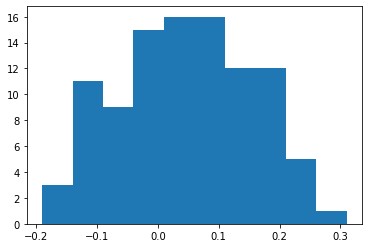

In [9]:
plt.hist(ls)
plt.show()

In [10]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.04920000000000003


### Counterfactual fairness

P(two_year_recid race=0 = 1 | race = 1, two_year_recid = 0)

In [11]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


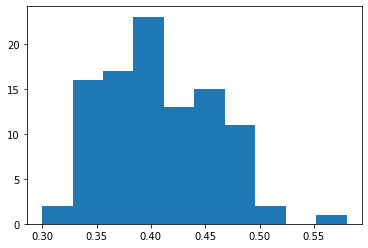

In [12]:
plt.hist(ls) 
plt.show()

In [13]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4078000000000001


### Average Total Effect

In [14]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.02699999999999997

### Natural Effects

#### Natural Direct Effects

In [15]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [16]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [17]:
e1_avg

0.329

In [18]:
e2_avg

0.328

In [19]:
e1_avg - e2_avg

0.0010000000000000009

#### Natural Indirect Effect

In [20]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'race': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(0)})() for _ in range(1000)]

In [21]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [22]:
e1_avg - e2_avg

0.25599999999999995

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [233]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [234]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.562


#### Sufficiency
$P(Y_{X=0} = 1 | X=1, Y=0)$

In [235]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [236]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.457


#### Necessity and Sufficiency
$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [237]:
num_trials = 1000
num_x0_y1 = 0
num_x1_y0 = 0
trace_handler = pyro.poutine.trace(model)
for _ in range(num_trials):
    trace = trace_handler.get_trace()
    x = trace.nodes['race']['value']
    y = trace.nodes['two_year_recid']['value']
    if x == 0 and y == 1:
        num_x0_y1 += 1
    if x == 1 and y == 0:
        num_x1_y0 += 1
pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
print('PNS =', pns)

PNS = 0.273883


## Model 1 - b) Analysis by Gender

### TP vs FN Rate

In [238]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    #if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for male defendants
y_test_ = truth[ df['sex']=='Male' ]
y_pred_ = preds[ df['sex']=='Male' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Male)      : ", fp/(fp+tn))
print("False negative rate (Male)      : ", fn/(fn+tp))
print("Accuracy (Male)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Male)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_male = fp/(fp+tn)
fnr_male =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['sex']=='Female' ]
y_pred_ = preds[ df['sex']=='Female' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (Female)      : ", fp/(fp+tn))
print("False negative rate (Female)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_female = fp/(fp+tn)
fnr_female =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_male-fpr_female))
print('False negative rate Gap:', abs(fnr_male-fnr_female))

False positive rate (Male)      :  0.4412783981517135
False negative rate (Male)      :  0.48671808054841476
Accuracy (Male)      :   0.5372135469478807
AUC (Male)      :   0.5360017606499359

False positive rate (Female)      :  0.40804597701149425
False negative rate (Female)      :  0.5391969407265774
Accuracy (White)      :   0.5356849876948319
AUC (White)      :   0.5263785411309642

False positive rate Gap: 0.03323242114021924
False negative rate Gap: 0.05247886017816267


### Intervention
P(two_year_recid=1 | do(sex=1)) - P(two_year_recid=1 | do(sex=0))

In [239]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'sex': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


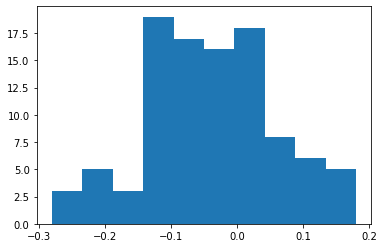

In [240]:
plt.hist(ls)
plt.show()

In [241]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

-0.041199999999999994


### Counterfactual fairness

P(two_year_recid sex=0 = 1 | sex = 1, two_year_recid = 0)

In [242]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"sex": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        r = trace.nodes['race']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"sex": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 34.50it/s]


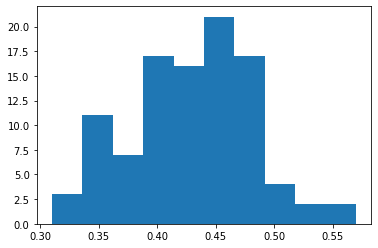

In [243]:
plt.hist(ls) 
plt.show()

In [244]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4281999999999999


### Average Total Effect

In [245]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'sex': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'sex': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

0.059

### Natural Effects

#### Natural Direct Effects

In [246]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'sex': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'sex': torch.tensor(0)})() for _ in range(1000)]

In [247]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [248]:
e1_avg

0.351

In [249]:
e2_avg

0.321

In [250]:
e1_avg - e2_avg

0.02999999999999997

#### Natural Indirect Effect

In [251]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'sex': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(0)})() for _ in range(1000)]

In [252]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [253]:
e1_avg - e2_avg

0.24099999999999994

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [254]:
cond_model = pyro.condition(model, data = {"sex": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    r = trace.nodes['race']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"sex": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [255]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.522


#### Sufficiency
$P(Y_{X=0} = 1 | X=1, Y=0)$

In [256]:
cond_model = pyro.condition(model, data = {"sex": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    r = trace.nodes['race']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [257]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.426


#### Necessity and Sufficiency
$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [259]:
num_trials = 1000
num_x0_y1 = 0
num_x1_y0 = 0
trace_handler = pyro.poutine.trace(model)
for _ in range(num_trials):
    trace = trace_handler.get_trace()
    x = trace.nodes['sex']['value']
    y = trace.nodes['two_year_recid']['value']
    if x == 0 and y == 1:
        num_x0_y1 += 1
    if x == 1 and y == 0:
        num_x1_y0 += 1
        
pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
print('PNS =', pns)

PNS = 0.21112799999999998


## Model 1 -  c) Analysis by Race + Gender

### TP vs FN Rate

In [260]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    #if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

## all scores for black defendants
# score for black and male defendants
y_test_ = truth[(df['race']=='African-American') & (df['sex']=='Male') ]
y_pred_ = preds[(df['race']=='African-American') & (df['sex']=='Male')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (African-American and Male)      : ", fp/(fp+tn))
print("False negative rate (African-American and Male)      : ", fn/(fn+tp))
print("Accuracy (African-American and Male)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (African-American and Male)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black_male = fp/(fp+tn)
fnr_black_male =  fn/(fn+tp)

print('')
# score for black and female defendants
y_test_ = truth[(df['race']=='African-American') & (df['sex']=='Female')]
y_pred_ = preds[(df['race']=='African-American') & (df['sex']=='Female')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (African-American and Female)      : ", fp/(fp+tn))
print("False negative rate (African-American and Female)      : ", fn/(fn+tp))
print("Accuracy (African-American and Female)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (African-American and Female)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black_female = fp/(fp+tn)
fnr_black_female =  fn/(fn+tp)

## all scores for white defendants
print('')
# scores for white and male defendants
y_test_ = truth[(df['race']=='Caucasian') & (df['sex']=='Male') ]
y_pred_ = preds[(df['race']=='Caucasian') & (df['sex']=='Male')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Caucasian and Male)      : ", fp/(fp+tn))
print("False negative rate (Caucasian and Male)      : ", fn/(fn+tp))
print("Accuracy (Caucasian and Male)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Caucasian and Male)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white_male = fp/(fp+tn)
fnr_white_male =  fn/(fn+tp)

print('')
# scores for white and female defendants
y_test_ = truth[(df['race']=='Caucasian') & (df['sex']=='Female') ]
y_pred_ = preds[(df['race']=='Caucasian') & (df['sex']=='Female')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Caucasian and Female)      : ", fp/(fp+tn))
print("False negative rate (Caucasian and Female)      : ", fn/(fn+tp))
print("Accuracy (Caucasian and Female)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Caucasian and Female)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white_female = fp/(fp+tn)
fnr_white_female =  fn/(fn+tp)

### calculate gaps
## race gap with same gender
# African-American versus Caucasian Males
print('\nFalse positive rate Gap across African-American versus Caucasian Males:', abs(fpr_black_male-fpr_white_male))
print('False negative rate Gap across African-American versus Caucasian Males:', abs(fnr_black_male-fnr_white_male))
# African-American versus Caucasian Female
print('\nFalse positive rate Gap across African-American versus Caucasian Females:', abs(fpr_black_female-fpr_white_female))
print('False negative rate Gap across African-American versus Caucasian Females:', abs(fnr_black_female-fnr_white_female))
## race gap versus different gender
# African-American Male versus Caucasian Female
print('\nFalse positive rate Gap across African-American Male versus Caucasian Female:', abs(fpr_black_male-fpr_white_female))
print('False negative rate Gap across African-American Male versus Caucasian Female:', abs(fnr_black_male-fnr_white_female))
# African-American Female versus Caucasian Male
print('\nFalse positive rate Gap across African-American Female versus Caucasian Male:', abs(fpr_black_female-fpr_white_male))
print('False negative rate Gap across African-American Female versus Caucasian Male:', abs(fnr_black_female-fnr_white_male))


0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (African-American and Male)      :  0.45110410094637227
False negative rate (African-American and Male)      :  0.4578478409869774
Accuracy (African-American and Male)      :   0.5456636005256241
AUC (African-American and Male)      :   0.5455240290333251


False positive rate (African-American and Female)      :  0.42613636363636365
False negative rate (African-American and Female)      :  0.55
Accuracy (African-American and Female)      :   0.5168711656441718
AUC (African-American and Female)      :   0.5119318181818182

False positive rate (Caucasian and Male)      :  0.4445534838076546
False negative rate (Caucasian and Male)      :  0.5529953917050692
Accuracy (Caucasian and Male)      :   0.505564387917329
AUC (Caucasian and Male)      :   0.5012255622436381

False positive rate (Caucasian and Female)      :  0.3885542168674699
False negative rate (Caucasian and Female)      :  0.4765957446808511
Accuracy (Caucasian and Female)    

### Intervention

In [207]:
ls = []
combos = [(0, 0), (1, 0)]
for combo in combos:
    num_sample = 20
    P_y1_do = {}
    cur_ls = []
    for run in tqdm.tqdm(range(20)):
        for x in [0,1]:
            do_model = pyro.do(model, data={ 'race': torch.tensor( combo[0] ), 'sex': torch.tensor(combo[1])  })
            posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
            marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
            samples = np.array([marginal().item() for _ in range(num_sample)])
            e_unique, e_counts = np.unique(samples, return_counts=True)
            dic = dict( zip(e_unique, e_counts) )
            P_y1_do[ x ] = dic[ 1 ] / num_sample
        diff = P_y1_do[0] - P_y1_do[1]
        cur_ls += [ diff ]
    ls.append(cur_ls)

100%|██████████| 20/20 [00:01<00:00, 19.89it/s]


In [208]:
for items, combo in zip(ls, combos):
    total = 0
    for x in items:
        total = total + x
    print(race_alias[combo[0]], sex_alias[combo[1]],'Intervention:' , total / len(ls))

African-American Female Intervention: 0.8750000000000001
Caucasian Female Intervention: -0.2500000000000001


### Counterfactual fairness

P(two_year_recid sex=0 = 1 | sex = 1, two_year_recid = 0)

In [206]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"sex": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
combos = [(0, 0), (1, 0)]
for run in tqdm.tqdm(range(100)):
    z = 0
    for combo in combos:
        cur_ls = []
        for _ in range(num_sample):
            trace = posterior()
            r = trace.nodes['race']['value']
            a = trace.nodes['age_cat']['value']
            c = trace.nodes['priors_count']['value']
            do_model = pyro.do(model, data = {"race": torch.tensor(combo[0]), 'sex': torch.tensor(combo[1])})
            counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
            trace_counterfactual = pyro.poutine.trace(counterfactual_model)
            trace = trace_counterfactual.get_trace()
            z += trace.nodes['two_year_recid']['value']
        cur_ls += [ float(z)/num_sample ]
    ls.append(cur_ls)
    
for items, combo in zip(ls, combos):
    total = 0
    for x in items:
        total = total + x
    print(race_alias[combo[0]], sex_alias[combo[1]],'Counterfactual:' , total / len(ls))

100%|██████████| 100/100 [00:06<00:00, 16.10it/s]

African-American Female Counterfactual: 0.0084
Caucasian Female Counterfactual: 0.0092


### Average Total Effect

In [176]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'sex': torch.tensor(1), 'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'sex': torch.tensor(0), 'race': torch.tensor(1)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
te = e1_avg - e2_avg
print(race_alias[0], sex_alias[1], 'versus' ,race_alias[1], sex_alias[0],'TE' ,te)

African-American Male versus Caucasian Female TE 0.034999999999999976


In [177]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'sex': torch.tensor(1), 'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'sex': torch.tensor(0), 'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
te = e1_avg - e2_avg
print(race_alias[1], sex_alias[1], 'versus' ,race_alias[0], sex_alias[0],'TE' ,te)

Caucasian Male versus African-American Female TE -0.008000000000000007


### Natural Effects

#### Natural Direct Effects

In [180]:
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'sex': torch.tensor(1), 'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'sex': torch.tensor(0), 'race': torch.tensor(1)})() for _ in range(1000)]

e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

nde = e1_avg - e2_avg
print(race_alias[0], sex_alias[1], 'versus' ,race_alias[1], sex_alias[0],'NDE', nde)

African-American Male versus Caucasian Female NDE -0.02999999999999997


In [181]:
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'sex': torch.tensor(1), 'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'sex': torch.tensor(0), 'race': torch.tensor(0)})() for _ in range(1000)]

e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

nde = e1_avg - e2_avg
print(race_alias[1], sex_alias[1], 'versus' ,race_alias[0], sex_alias[0],'NDE', nde)

Caucasian Male versus African-American Female NDE -0.01100000000000001


#### Natural Indirect Effect

In [203]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))

combos = [(0, 0), (1, 0)]
for combo in combos:
    race_index = combo[0]
    sex_index = combo[1]
    cond_model = pyro.condition(model, data={'sex': torch.tensor(sex_index), 'race': torch.tensor(race_index)})
    e1_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(1)})() for _ in range(1000)]
    e2_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(0)})() for _ in range(1000)]

    e1_avg = sum(e1_samples).item() / len(e1_samples)
    e2_avg = sum(e2_samples).item() / len(e2_samples)

    nie = e1_avg - e2_avg

    print('NIE of', race_alias[race_index], sex_alias[sex_index], ':', nie)

NIE of African-American Female : 0.23399999999999993
NIE of Caucasian Female : 0.26799999999999996


### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [263]:
stored_necessity = list()
combos = [(1, 1), (1, 0)]
for combo in combos:
    race_index = combo[0]
    sex_index = combo[1]

    cond_model = pyro.condition(model, data = {"sex": torch.tensor(swap_value(sex_index)), "race": torch.tensor(swap_value(race_index)), "two_year_recid": torch.tensor(1)})
    posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
    p_necessities = []
    for _ in range(1000):
        trace = posterior()
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"sex": torch.tensor(sex_index), "race": torch.tensor(race_index)})
        counterfactual_model = pyro.condition(do_model, data = {'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        p_necessities.append(float(trace.nodes['two_year_recid']['value']))

    p_necessity = 1 - mean(p_necessities)
    stored_necessity.append(p_necessity)
    print("P necessity with", race_alias[race_index], sex_alias[sex_index],':' , p_necessity)

P necessity with Caucasian Male : 0.528
P necessity with Caucasian Female : 0.487


#### Sufficiency

In [264]:
stored_sufficiency = list()
combos = [(1, 1), (1, 0)]
for combo in combos:
    race_index = combo[0]
    sex_index = combo[1]

    cond_model = pyro.condition(model, data = {"sex": torch.tensor(sex_index), "race": torch.tensor(race_index), "two_year_recid": torch.tensor(0)})
    posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
    p_sufficiencies = []
    for _ in range(1000):
        trace = posterior()
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(swap_value(race_index)), "sex": torch.tensor(swap_value(sex_index))})
        counterfactual_model = pyro.condition(do_model, data = {'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

    p_sufficiency = mean(p_sufficiencies)
    stored_sufficiency.append(p_sufficiency)
    print("P necessity of", race_alias[swap_value(race_index)], sex_alias[swap_value(sex_index)], p_sufficiency)

P necessity of African-American Female 0.469
P necessity of African-American Male 0.371


#### Necessity and Sufficiency
$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [266]:
for p_necessity, p_sufficiency, index in zip(stored_necessity, stored_sufficiency, ((1, 1), (1, 0))):
    num_trials = 1000
    num_x0_y1 = 0
    num_x1_y0 = 0
    trace_handler = pyro.poutine.trace(model)
    for _ in range(num_trials):
        trace = trace_handler.get_trace()
        x = trace.nodes['race']['value']
        y = trace.nodes['two_year_recid']['value']
        if x == 0 and y == 1:
            num_x0_y1 += 1
        if x == 1 and y == 0:
            num_x1_y0 += 1
    pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
    race_alias[race_index], sex_alias[sex_index]
    print('PNS of', race_alias[index[0]], sex_alias[index[1]], ':', pns)

PNS of Caucasian Male : 0.258353
PNS of Caucasian Female : 0.22331299999999998


## Model 2 - Direct Race Path

### Read Model Parameters

In [267]:
# race
df = pd.read_csv('data/model2_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model2_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model2_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# priors_count
df = pd.read_csv('data/model2_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in priors_count_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

priors_count_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model2_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['priors_count'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in priors_count_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

### Define model

In [268]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][priors_count]))
    return two_year_recid

In [269]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    #if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

False positive rate (Black)      :  0.48574686431014824
False negative rate (Black)      :  0.44850669412976313
Accuracy (Black)      :   0.5338203463203464
AUC (Black)      :   0.5328732207800443

False positive rate (White)      :  0.3781569965870307
False negative rate (White)      :  0.5712841253791708
Accuracy (White)      :   0.5440097799511002
AUC (White)      :   0.5252794390168992

False positive rate Gap: 0.10758986772311752
False negative rate Gap: 0.12277743124940771


### Intervention

You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
where two_year_recid=1 represents recidivism, 
race=0 represents "African-American" 
race=1 represents "Caucasian" 

In [270]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


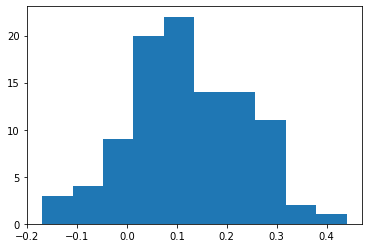

In [271]:
plt.hist(ls) 
plt.show()

In [272]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.12249999999999998


### Counterfactual fairness

In [273]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 34.59it/s]


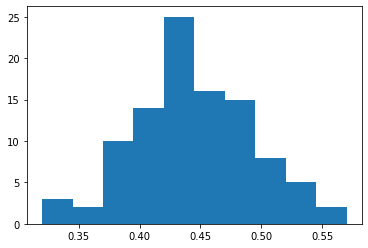

In [274]:
plt.hist(ls)
plt.show()

In [275]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4425999999999999


### Average Total Effects

In [276]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.14900000000000002

### Natural effects

#### Natural Direct Effects

In [277]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [278]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [279]:
e1_avg

0.271

In [280]:
e2_avg

0.367

In [281]:
e1_avg - e2_avg

-0.09599999999999997

#### Natural Indirect Effects

In [282]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'priors_count': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [283]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [284]:
e1_avg - e2_avg

0.22399999999999998

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [285]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [286]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.538


#### Sufficiency
$P(Y_{X=0} = 1 | X=1, Y=0)$

In [287]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [288]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.478


#### Necessity and Sufficiency
$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [289]:
num_trials = 1000
num_x0_y1 = 0
num_x1_y0 = 0
trace_handler = pyro.poutine.trace(model)
for _ in range(num_trials):
    trace = trace_handler.get_trace()
    x = trace.nodes['race']['value']
    y = trace.nodes['two_year_recid']['value']
    if x == 0 and y == 1:
        num_x0_y1 += 1
    if x == 1 and y == 0:
        num_x1_y0 += 1
pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
print('PNS =', pns)

PNS = 0.28634000000000004


## Model 3 - Unaware by Race

### Read data

In [290]:
# race
df = pd.read_csv('data/model3_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model3_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model3_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# priors_count
df = pd.read_csv('data/model3_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[( row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l1 = []
for s in sex_alias:
    l2 = []
    for a in age_cat_alias:
        l3 = []
        for c in priors_count_alias:            
            l3 += [ dic[s,a,c] ]
        l2 +=  [ l3 ]
    l1 += [ l2 ]

priors_count_probs = torch.tensor( l1 )

# two_year_recid
df = pd.read_csv('data/model3_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in priors_count_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define model

In [291]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[priors_count]))
    return two_year_recid


### Association

In [292]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    #if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

False positive rate (Black)      :  0.44415983606557374
False negative rate (Black)      :  0.4994266055045872
Accuracy (Black)      :   0.5297619047619048
AUC (Black)      :   0.5282067792149195

False positive rate (White)      :  0.40427098674521356
False negative rate (White)      :  0.541970802919708
Accuracy (White)      :   0.5342298288508558
AUC (White)      :   0.5268791051675392

False positive rate Gap: 0.03988884932036019
False negative rate Gap: 0.04254419741512083


### Intervention

In [73]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

In [293]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


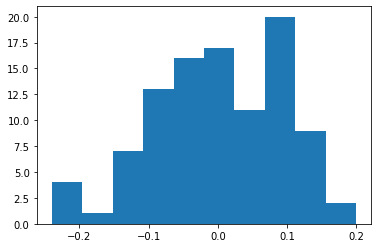

In [294]:
plt.hist(ls)
plt.show()

In [295]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.004000000000000001


### Counterfactual fairness

In [296]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

In [297]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 35.45it/s]


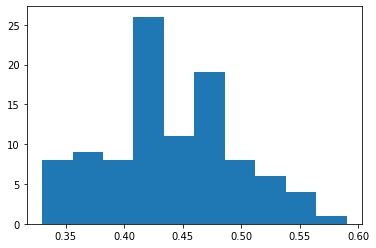

In [298]:
plt.hist(ls)
plt.show()

In [299]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.43860000000000005


In [300]:
# P(two_year_recid race=1 = 1|race = 0,two_year_recid = 1)

In [301]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(1)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 34.60it/s]


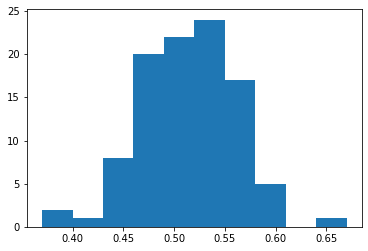

In [302]:
plt.hist(ls)
plt.show()

In [303]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.5104000000000002


### Average Total Effects

In [304]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.01899999999999996

### Natural effects

#### Natural Direct Effects

In [305]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [306]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [307]:
e1_avg

0.335

In [308]:
e2_avg

0.343

In [309]:
e1_avg - e2_avg

-0.008000000000000007

#### Natural Indirect Effects

In [310]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'priors_count': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [311]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [312]:
e1_avg - e2_avg

0.25399999999999995

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [313]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [314]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.52


#### Sufficiency
$P(Y_{X=0} = 1 | X=1, Y=0)$

In [315]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [316]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.432


#### Necessity and Sufficiency
$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [317]:
num_trials = 1000
num_x0_y1 = 0
num_x1_y0 = 0
trace_handler = pyro.poutine.trace(model)
for _ in range(num_trials):
    trace = trace_handler.get_trace()
    x = trace.nodes['race']['value']
    y = trace.nodes['two_year_recid']['value']
    if x == 0 and y == 1:
        num_x0_y1 += 1
    if x == 1 and y == 0:
        num_x1_y0 += 1
pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
print('PNS =', pns)

PNS = 0.22115200000000002
